:
# How common is introduced unfairness

In the paper

*Why fair lables can yield unfair predictions: graphical conditions on introduced unfairness*  
Carolyn Ashurst, Ryan Carey, Silvia Chiappa, Tom Everitt  
AAAI, 2022


we explore conditions under which fair labels can yield optimal unfair models. This notebook illustrates how PyCID can be used to investigate this question, by defining methods for graphical criteria and randomly sampling supervised learning CIDs.

In [2]:
# @title Imports

#importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid
    import pycid
    
import numpy as np
import networkx as nx
import random

  Cloning https://github.com/causalincentives/pycid to /tmp/pip-req-build-5f572fm9
  Running command git clone -q https://github.com/causalincentives/pycid /tmp/pip-req-build-5f572fm9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 324 kB 5.3 MB/s 
  Created wheel for pycid: filename=pycid-0.2.9.dev6+ga0ea362-py3-none-any.whl size=53837 sha256=fc173424c9e91bee103e4a6aca8e24b654901c45ee7a0dc1c3983fb3255db09d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1rdkqyaq/wheels/c9/03/bf/ed5e61b0eea9dcb4db2f2e5105567f0a3d7c651ae75836c45a
Successfully built pycid


## Definitions

Define ITV and methods for checking the graphical conditions

In [3]:
def max_total_variation(cid: pycid.CID, a: str, x) -> float:
    """the maximum total variation on x from conditioning on a"""
    evs = [cid.expected_value([x], {a: a1})[0] for a1 in cid.model.domain['A']]
    return max(evs) - min(evs)


def introduced_total_variation(cid: pycid.CID, a: str, d: str, y: str) -> float:
    """The total introduced variation, comparing the effect of a on d and y"""
    tv_d = max_total_variation(cid, a, d)
    tv_y = max_total_variation(cid, a, y)
    return tv_d - tv_y
  
def theorem9(cid):
  """ITV is possible under arbitrary loss"""
  for x in cid.get_parents('D'):
    condition = ['D'] + cid.get_parents('D')
    condition.remove(x)
    if cid.is_active_trail('A', x, []) and cid.is_active_trail(x, 'U', condition):
      return True
  return False

def theorem11(cid):
  """ITV is possible under P-admissible loss"""
  return theorem9(cid) and not 'A' in cid.get_parents('D') and cid.is_active_trail('A', 'U', ['D'] + cid.get_parents('D'))

## Generate random supervised learning CIDs

Here we create a method to generate a random supervised learning CID, with 'special' nodes D, Y, U, and A. The only parents of U are D and Y, and D only has a single child U.

In [8]:
def random_supervised_learning_cid(number_of_nodes: int = 6, 
                                   edge_density: float = 0.4) -> pycid.CID:
    """
    Generates a CID with 'special' nodes D, Y, U, and A to model a supervised
    learning setup. 
    The only parents of U are D and Y, and D only has a single child U.
    
    The graph is always connected. The edge_density parameter specifies how many
    edges are added additionally.
    
    Parameters:
    -----------
    number_of_nodes: how many nodes in the graph
    edge_density: how densely connected is the graph, between 0 and 1
    """
    dag = pycid.random_dag(number_of_nodes=number_of_nodes-1, edge_density=edge_density)
    remaning_nodes = list(nx.topological_sort(dag))
    # choose a decision node
    decision_node = remaning_nodes.pop()
    # choose a label node
    y_node = random.choice(remaning_nodes)
    remaning_nodes.remove(y_node)
    # choose a sensitive attribute
    a_node = random.choice(remaning_nodes)
    remaning_nodes.remove(a_node)
    # add appropriate names, and add a U node
    dag = nx.relabel_nodes(dag, {decision_node: 'D', y_node: 'Y', a_node: 'A'})
    dag.add_edge('D', 'U')
    dag.add_edge('Y', 'U')

    # convert the DAG into a CID with labeled decisions and utilities
    cid = pycid.CID(dag.edges, decisions=['D'], utilities=['U'])

    # add random cpds and a 0-1 loss function
    cid.add_cpds(
        D = [0, 1],
        U = lambda d, y: int(d==y),  # 0-1 loss function
        A = pycid.random_cpd.RandomCPD(),
        Y = pycid.random_cpd.RandomCPD(),
      )
    for n in remaning_nodes:
        cid.add_cpds(**{n: pycid.random_cpd.RandomCPD()})

    return cid

## Investigating a single CID

Before sampling repeatedly to get statistical estimates, let us investigate a single, randomly sampled CID. Rerun the code to see different samples.

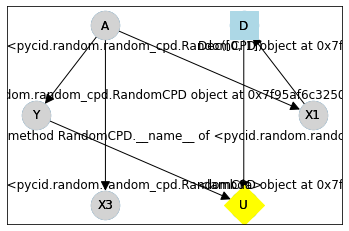

ITV under 0-1 loss possible:  True
ITV under 0-1 loss possible:  True
actual ITV under 0-1 loss -0.27022906322955986
actual ITV under P-adm loss -0.2654866312511974


In [39]:
cid = random_supervised_learning_cid()
cid.draw()
print("ITV under 0-1 loss possible: ", theorem9(cid))
print("ITV under 0-1 loss possible: ", theorem11(cid))

# impute an optimal policy under the specified 0-1 loss, and compute actual ITV
cid.impute_optimal_policy()
print("actual ITV under 0-1 loss", introduced_total_variation(cid, 'A', 'D', 'Y'))

# the optimal policy under P-admissible loss is the conditional expectation.
# We impute that policy instead, and recompute ITV
cid.impute_conditional_expectation_decision('D', 'Y')
print("actual ITV under P-adm loss", introduced_total_variation(cid, 'A', 'D', 'Y'))

## Sample CIDs and measure ITV

Now let's sample 20 different CIDs, and count how many have an introduced total effect under 0-1 loss, and under P-admissible loss. Increase the iterations parameter to get more reliable estimates.

In [23]:
samples = 20

theorem9_total = 0
theorem9_results = []

while theorem9_total < samples:
    cid = random_supervised_learning_cid()

    if theorem9(cid):
      theorem9_total += 1
      cid.impute_optimal_policy()
      theorem9_results.append(introduced_total_variation(cid, 'A', 'D', 'Y'))
      theorem9_rate = sum(i > 0.01 for i in theorem9_results)/theorem9_total
      print("{:.2f}".format(theorem9_rate) + f" positive under 0-1 loss, count {theorem9_total}")
    else:
      continue  # if the CID doesn't satisfy the graphical condition, we resample

0.00 positive under 0-1 loss, count 1
0.00 positive under 0-1 loss, count 2
0.00 positive under 0-1 loss, count 3
0.00 positive under 0-1 loss, count 4
0.00 positive under 0-1 loss, count 5
0.00 positive under 0-1 loss, count 6
0.00 positive under 0-1 loss, count 7
0.00 positive under 0-1 loss, count 8
0.00 positive under 0-1 loss, count 9
0.00 positive under 0-1 loss, count 10
0.00 positive under 0-1 loss, count 11
0.00 positive under 0-1 loss, count 12
0.08 positive under 0-1 loss, count 13
0.07 positive under 0-1 loss, count 14
0.07 positive under 0-1 loss, count 15
0.06 positive under 0-1 loss, count 16
0.06 positive under 0-1 loss, count 17
0.06 positive under 0-1 loss, count 18
0.05 positive under 0-1 loss, count 19
0.05 positive under 0-1 loss, count 20


In [24]:
samples = 20

theorem11_total = 0
theorem11_results = []

while theorem11_total < samples:
    cid = random_supervised_learning_cid()

    if theorem11(cid):
      theorem11_total += 1
      # impute the policy that'd be optimal under P-admissible loss
      cid.impute_conditional_expectation_decision('D', 'Y') 
      theorem11_results.append(introduced_total_variation(cid, 'A', 'D', 'Y'))
      theorem11_rate = sum(i > 0.01 for i in theorem11_results)/theorem11_total
      print("{:.2f}".format(theorem11_rate) + f" positive under P-adm loss, count {theorem11_total}")
    else:
      continue  # if the CID doesn't satisfy the graphical condition, we resample

0.00 positive under P-adm loss, count 1
0.00 positive under P-adm loss, count 2
0.00 positive under P-adm loss, count 3
0.00 positive under P-adm loss, count 4
0.00 positive under P-adm loss, count 5
0.00 positive under P-adm loss, count 6
0.14 positive under P-adm loss, count 7
0.12 positive under P-adm loss, count 8
0.11 positive under P-adm loss, count 9
0.10 positive under P-adm loss, count 10
0.18 positive under P-adm loss, count 11
0.25 positive under P-adm loss, count 12
0.23 positive under P-adm loss, count 13
0.21 positive under P-adm loss, count 14
0.27 positive under P-adm loss, count 15
0.31 positive under P-adm loss, count 16
0.29 positive under P-adm loss, count 17
0.28 positive under P-adm loss, count 18
0.26 positive under P-adm loss, count 19
0.25 positive under P-adm loss, count 20
